# Setup imports and setups

In [7]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score

module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_loader import load_kaggle_csv, make_sequences

# Configuration
DATA_PATH = '../data/rain_prediction_dataset.csv' 
REGRESSOR_PATH = '../models/lstm_regressor.h5'
CLASSIFIER_PATH = '../models/lstm_classifier.h5'
LOOKBACK = 14

print("Setup Complete. Libraries and Source Code loaded.")

Setup Complete. Libraries and Source Code loaded.


# Load and Prepare Data

In [8]:
# 1. Load the raw data
df = load_kaggle_csv(target_col='Precipitation')

# 2. Prepare Data for regression (Rainfall Amount)
reg_values = df.values
reg_scaler = MinMaxScaler(feature_range=(0, 1))
reg_scaled = reg_scaler.fit_transform(reg_values)

# Create sequences
target_col_idx = df.columns.get_loc('Precipitation')
X_reg, y_reg = make_sequences(reg_scaled, LOOKBACK, target_col_idx)

# Split 
train_size = int(len(X_reg) * 0.8)
X_test_reg = X_reg[train_size:]
y_test_reg = y_reg[train_size:]

# Prepare inverse scaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(reg_values[:, target_col_idx].reshape(-1, 1))

print(f"Test Data Ready. Samples: {len(X_test_reg)}")

Loading data from: c:\Users\Alvaro\OneDrive\Documents\Custom Office Templates\Desktop\Github\Fall_Projects\ML-Project\src\..\data\rain_prediction_dataset.csv
Filtering data for location: New York
Final dataset shape: (3655, 7)
Test Data Ready. Samples: 729


# Regression Analysis (Rainfall Amount)

Regressor Model Loaded successfully.
------------------------------
Mean Absolute Error (MAE): 0.37 mm
Mean Squared Error (MSE):  0.2091
R² Score:                  -0.0068
------------------------------


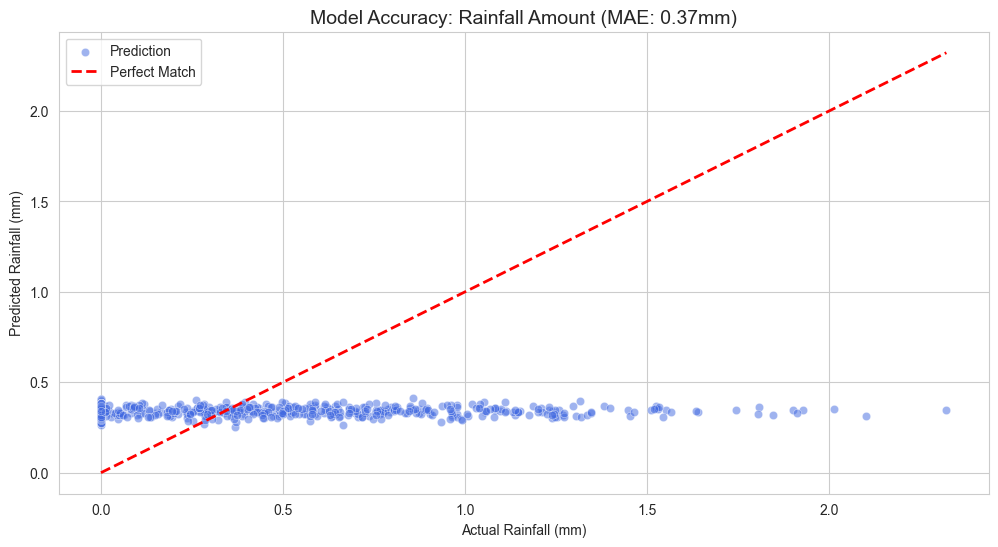

In [9]:
# 1. Load Model
if os.path.exists(REGRESSOR_PATH):
    regressor = load_model(REGRESSOR_PATH)
    print("Regressor Model Loaded successfully.")
else:
    print("Error: Regressor model file missing!")

# 2. Predict
preds_scaled = regressor.predict(X_test_reg, verbose=0)

# 3. Inverse Transform (Get real mm values)
y_actual_mm = target_scaler.inverse_transform(y_test_reg.reshape(-1, 1))
y_pred_mm = target_scaler.inverse_transform(preds_scaled)

# 4. Metrics
mae = mean_absolute_error(y_actual_mm, y_pred_mm)
mse = mean_squared_error(y_actual_mm, y_pred_mm)  
r2 = r2_score(y_actual_mm, y_pred_mm)

print("-" * 30)
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")
print(f"Mean Squared Error (MSE):  {mse:.4f}")      
print(f"R² Score:                  {r2:.4f}")
print("-" * 30)

# 5. Visualization: Actual vs Predicted
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.scatterplot(x=y_actual_mm.flatten(), y=y_pred_mm.flatten(), alpha=0.5, color='royalblue', label='Prediction')

# Perfect Line
min_val = min(y_actual_mm.min(), y_pred_mm.min())
max_val = max(y_actual_mm.max(), y_pred_mm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Match')

plt.title(f'Model Accuracy: Rainfall Amount (MAE: {mae:.2f}mm)', fontsize=14)
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.legend()
plt.show()

# Classification Analysis (Storm Detection)

Classifier Model Loaded successfully.


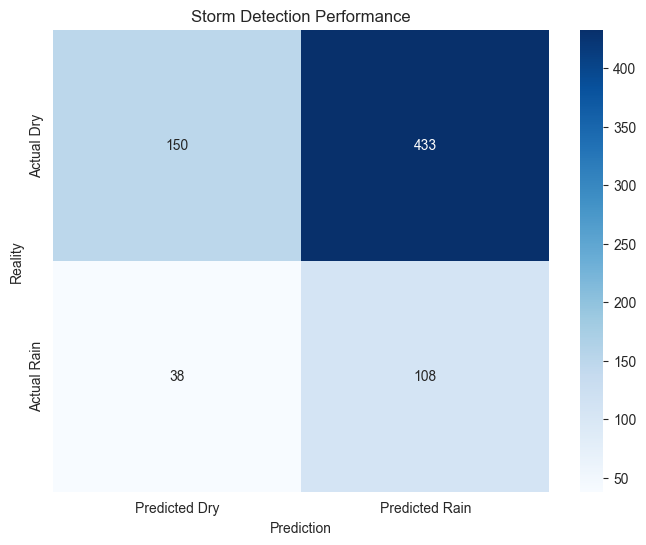


Classification Report:
              precision    recall  f1-score   support

     No Rain       0.80      0.26      0.39       583
        Rain       0.20      0.74      0.31       146

    accuracy                           0.35       729
   macro avg       0.50      0.50      0.35       729
weighted avg       0.68      0.35      0.37       729



In [10]:
# 1. Load Model
if os.path.exists(CLASSIFIER_PATH):
    classifier = load_model(CLASSIFIER_PATH)
    print("Classifier Model Loaded successfully.")
else:
    print("Error: Classifier model file missing!")

# 2. Prepare Data (Re-using sequences, but target is different column)
target_class_idx = df.columns.get_loc('Rain Tomorrow')
X_class, y_class = make_sequences(reg_scaled, LOOKBACK, target_class_idx) # Inputs are same, target changes

# Split Test Set
X_test_class = X_class[train_size:]
y_test_class = y_class[train_size:]

# 3. Predict
class_preds_prob = classifier.predict(X_test_class, verbose=0)
class_preds = (class_preds_prob > 0.5).astype(int)

# 4. Visualizing the Confusion Matrix
cm = confusion_matrix(y_test_class, class_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Dry', 'Predicted Rain'],
            yticklabels=['Actual Dry', 'Actual Rain'])
plt.title('Storm Detection Performance')
plt.ylabel('Reality')
plt.xlabel('Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_class, class_preds, target_names=['No Rain', 'Rain']))

# Interactive "Weather Simulator"

In [12]:
import random

# Pick a random day from the test set
random_idx = random.randint(0, len(X_test_reg) - 1)
sample_input = X_test_reg[random_idx].reshape(1, LOOKBACK, 7) # Shape (1, 14, 7)

# Get Predictions
rain_amount = regressor.predict(sample_input, verbose=0)
rain_prob = classifier.predict(sample_input, verbose=0)

# Convert to human-readable
real_mm = target_scaler.inverse_transform(y_test_reg[random_idx].reshape(-1,1))[0][0]
pred_mm = target_scaler.inverse_transform(rain_amount)[0][0]
storm_chance = rain_prob[0][0] * 100
did_it_rain = "YES" if y_test_class[random_idx] == 1 else "NO"

# Display Results
print(f"--- WEATHER SIMULATION (Day #{random_idx}) ---")
print(f"History:    Based on the previous 14 days of weather...")
print(f"\nREALITY:")
print(f"  Did it rain?      {did_it_rain}")
print(f"  Amount:           {real_mm:.2f} mm")
print(f"\nMODEL PREDICTIONS:")
print(f"  Storm Probability: {storm_chance:.1f}%")
print(f"  Predicted Amount:  {pred_mm:.2f} mm")

if abs(real_mm - pred_mm) < 2.0:
    print("\n Good Prediction with 1 city!")
else:
    print("\n❌ Missed by a bit.")

--- WEATHER SIMULATION (Day #242) ---
History:    Based on the previous 14 days of weather...

REALITY:
  Did it rain?      YES
  Amount:           1.20 mm

MODEL PREDICTIONS:
  Storm Probability: 48.1%
  Predicted Amount:  0.33 mm

 Good Prediction with 1 city!
